## Problem Statement
Given a dataset containing Shakespear sonets, build a model to generate the next 30 words after a starter sentence.

## Import Libraries

In [5]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, Bidirectional, Dense, LSTM, Dropout
from tensorflow.keras.models import Sequential 
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras import regularizers 
from tensorflow.keras import callbacks

import os
import numpy as np 
import tensorflow.keras.utils as ku


## Getting Dataset

In [1]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt \
    -O /tmp/sonnets.txt
data = open('/tmp/sonnets.txt').read()

--2021-01-15 16:43:40--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.189.128, 108.177.97.128, 108.177.125.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.189.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93578 (91K) [text/plain]
Saving to: ‘/tmp/sonnets.txt’

/tmp/sonnets.txt    100%[===================>]  91.38K  --.-KB/s    in 0.001s  

2021-01-15 16:43:40 (74.6 MB/s) - ‘/tmp/sonnets.txt’ saved [93578/93578]



## Unpacking dataset

In [ ]:
print(data[:250].lower())

from fairest creatures we desire increase,
that thereby beauty's rose might never die,
but as the riper should by time decease,
his tender heir might bear his memory:
but thou, contracted to thine own bright eyes,
feed'st thy light'st flame with self


## Initialise tokenizer 

In [8]:
tokenizer = Tokenizer()
corpus = data.lower().split("\n")  #split data into seperate sentences 
print(corpus[:3])

['from fairest creatures we desire increase,', "that thereby beauty's rose might never die,", 'but as the riper should by time decease,']


In [9]:
tokenizer.fit_on_texts(corpus)  # using tokenizer to fit texts
vocab = tokenizer.word_index


## Exploring vocabulary built by tokenizer

In [13]:
for word, value in zip(vocab, range(10)): 
  print(value,':', word)

0 : and
1 : the
2 : to
3 : of
4 : my
5 : i
6 : in
7 : that
8 : thy
9 : thou


In [23]:
total_words = len(vocab)+1
input_sequences = []
for line in corpus: 
  token_list = tokenizer.texts_to_sequences([line])[0]  #give a list to texts_to_sequences to return an array
  for i in range(len(token_list)): #generate data by appending new generated lists that were created by incrementing an additional word sequentially from a min of 2 words 
    lst = token_list[:i+2]
    input_sequences.append(lst)

## Padding Sequences

In [30]:
max_sequence_len = max([len(i) for i in input_sequences])  # checking longest sequence in corpus
print(max_sequence_len)

11


In [31]:
input_sequences = pad_sequences(input_sequences, maxlen= max_sequence_len, padding='pre')
print(input_sequences[:10])

[[  0   0   0   0   0   0   0   0   0  34 417]
 [  0   0   0   0   0   0   0   0  34 417 877]
 [  0   0   0   0   0   0   0  34 417 877 166]
 [  0   0   0   0   0   0  34 417 877 166 213]
 [  0   0   0   0   0  34 417 877 166 213 517]
 [  0   0   0   0   0  34 417 877 166 213 517]
 [  0   0   0   0   0   0   0   0   0   8 878]
 [  0   0   0   0   0   0   0   0   8 878 134]
 [  0   0   0   0   0   0   0   8 878 134 351]
 [  0   0   0   0   0   0   8 878 134 351 102]]


## Creating predictors & labels

In [32]:
predictors = input_sequences[:, : -1 ] #taking each list without the last index's value as the predictor
labels = input_sequences[:,-1]  #  along with last index's value as the label 
print(predictors[:10])
print(labels[:10])

[[  0   0   0   0   0   0   0   0   0  34]
 [  0   0   0   0   0   0   0   0  34 417]
 [  0   0   0   0   0   0   0  34 417 877]
 [  0   0   0   0   0   0  34 417 877 166]
 [  0   0   0   0   0  34 417 877 166 213]
 [  0   0   0   0   0  34 417 877 166 213]
 [  0   0   0   0   0   0   0   0   0   8]
 [  0   0   0   0   0   0   0   0   8 878]
 [  0   0   0   0   0   0   0   8 878 134]
 [  0   0   0   0   0   0   8 878 134 351]]
[417 877 166 213 517 517 878 134 351 102]


## One Hot encoding for labels

In [33]:
labels = ku.to_categorical(labels, num_classes = total_words)

In [34]:
labels[0].shape

(3211,)

## Model Architecture
using Embedding, Bidirection LSTM, Dense, Dropout layers

In [35]:
model = Sequential()
model.add(Embedding(total_words,128, input_length = max_sequence_len-1)) 
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Dropout(0.2))  # layer to randomly forget stuff to prevent overfitting
model.add(LSTM(64))
model.add(Dense(total_words/2, activation = 'relu', kernel_regularizer= regularizers.l2(0.01) ))
model.add(Dense(total_words, activation = 'softmax'))

model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [36]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 10, 128)           411008    
_________________________________________________________________
bidirectional (Bidirectional (None, 10, 256)           263168    
_________________________________________________________________
dropout (Dropout)            (None, 10, 256)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                82176     
_________________________________________________________________
dense (Dense)                (None, 1605)              104325    
_________________________________________________________________
dense_1 (Dense)              (None, 3211)              5156866   
Total params: 6,017,543
Trainable params: 6,017,543
Non-trainable params: 0
______________________________________________

## Callbacks

In [37]:
early_stop = callbacks.EarlyStopping(monitor = 'loss', patience =3 , verbose = 1)

In [38]:
epochs = 150
history = model.fit(predictors, labels, epochs= epochs,callbacks = [early_stop])

Epoch 1/150
551/551 [==============================] - 23s 24ms/step - loss: 7.2810 - accuracy: 0.0167
Epoch 2/150
551/551 [==============================] - 13s 24ms/step - loss: 6.5754 - accuracy: 0.0207
Epoch 3/150
551/551 [==============================] - 13s 24ms/step - loss: 6.4509 - accuracy: 0.0235
Epoch 4/150
551/551 [==============================] - 13s 24ms/step - loss: 6.2615 - accuracy: 0.0323
Epoch 5/150
551/551 [==============================] - 13s 24ms/step - loss: 6.0797 - accuracy: 0.0379
Epoch 6/150
551/551 [==============================] - 13s 24ms/step - loss: 5.9312 - accuracy: 0.0434
Epoch 7/150
551/551 [==============================] - 13s 24ms/step - loss: 5.7592 - accuracy: 0.0468
Epoch 8/150
551/551 [==============================] - 13s 24ms/step - loss: 5.6196 - accuracy: 0.0536
Epoch 9/150
551/551 [==============================] - 13s 24ms/step - loss: 5.4799 - accuracy: 0.0623
Epoch 10/150
551/551 [==============================] - 13s 24ms/step - l

## Visualising results

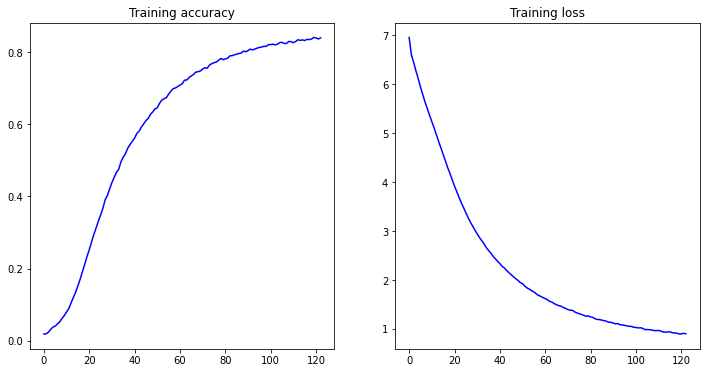

In [49]:
import matplotlib.pyplot as plt 
acc= history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,6))
ax1.plot(epochs, acc,'b', label='Training accuracy')
ax1.set_title('Training accuracy')

ax2.plot(epochs, loss,'b', label='Training loss')
ax2.set_title('Training loss')

plt.show();

## Predicting next 30 words

In [63]:
seed_text = "Help me Obi Wan Kenobi, you're truly wise"
next_words = 30
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = model.predict_classes(token_list, verbose=0)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Help me Obi Wan Kenobi, you're truly wise i am stol'n of many great muse wrong date steep torn date rage burn'd fall back quite seen seen rolling wrong store rolling burn each quite beard torn torn torn


## Future Steps
1. Improving model architecture to increase accuracy to ensure that predicted words make sense
2. Character-based NLP model architecture
3. 